In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import proxy_crm_modules as pCRM
from fractionalFlow import frac_flow
from pywaterflood import CrmCompensated

from timeit import default_timer as timer

In [84]:
np.set_printoptions(threshold=np.inf)

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data. P2 and P4 are modified to replicate shut in condition.</p>

In [85]:
# Base case.
data_src = "D:/crmProject/crmp_code_test/proxy_crm/data/test/"
oil_prod = pd.read_excel(data_src + 'Base_PROD.xlsx', header=None)
prod = pd.read_excel(data_src + "Base_LIQUID.xlsx", header=None)
inj = pd.read_excel(data_src + "Base_INJ.xlsx", header=None)
time = pd.read_excel(data_src + "TIME.xlsx", header= None)
pressure = pd.read_excel(data_src + "Base_BHP.xlsx", header=None)
wor = pd.read_excel(data_src + "Base_WOR.xlsx", header=None)
cwi = pd.read_excel(data_src + "Base_CWI.xlsx", header=None)

train_size = int(0.75 * prod.shape[0])

<p>This section is for loading the one and two well shut-in cases.</p>

In [86]:
# Single well shut-in case.
prod_shut_in1 = pd.read_excel(data_src + "ShutIn1_LIQUID.xlsx", header= None)
oil_prod_shut_in1 = pd.read_excel(data_src + 'ShutIn1_PROD.xlsx', header=None)
inj_shut_in1 = pd.read_excel(data_src + "ShutIn1_INJ.xlsx", header=None)
pressure_shut_in1 = pd.read_excel(data_src + "ShutIn1_BHP.xlsx", header=None)
wor_shut_in1 = pd.read_excel(data_src + "ShutIn1_WOR.xlsx", header=None)
cwi_shut_in1 = pd.read_excel(data_src + "ShutIn1_CWI.xlsx", header=None)

# Two well shut-in case
prod_shut_in2 = pd.read_excel(data_src + "ShutIn2_PROD.xlsx", header= None)
oil_prod_shut_in2 = pd.read_excel(data_src + 'ShutIn2_PROD.xlsx', header=None)
inj_shut_in2 = pd.read_excel(data_src + "ShutIn2_INJ.xlsx", header=None)
pressure_shut_in2 = pd.read_excel(data_src + "ShutIn2_BHP.xlsx", header=None)
wor_shut_in2 = pd.read_excel(data_src + "ShutIn2_WOR.xlsx", header=None)
cwi_shut_in2 = pd.read_excel(data_src + "ShutIn2_CWI.xlsx", header=None)

<p>Now, we can split it into train-test data. It is divided into 75-25%</p>

In [87]:
#Create train-test dataset for base case.
inj_train = inj.values[1:train_size]
prod_train = prod.values[1:train_size]
oil_prod_train = oil_prod.values[1:train_size]
time_train = time.values[1:train_size].astype('float')
press_train = pressure.values[1:train_size]

inj_test = inj.values[train_size:]
prod_test = prod.values[train_size:]
oil_prod_test = oil_prod.values[train_size:]
time_test = time.values[train_size:].astype('float')
press_test = pressure.values[train_size:]

# for single well shut-in case.
inj_shut_in1_train = inj_shut_in1.values[1:train_size]
prod_shut_in1_train = prod_shut_in1.values[1:train_size]
oil_prod_shut_in1_train = oil_prod_shut_in1.values[1:train_size]
press_shut_in1_train = pressure_shut_in1.values[1:train_size]

inj_shut_in1_test = inj_shut_in1.values[train_size:]
prod_shut_in1_test = prod_shut_in1.values[train_size:]
oil_prod_shut_in1_test = oil_prod_shut_in1.values[train_size:]
press_shut_in1_test = pressure_shut_in2.values[train_size:]

# for two well shut-in case.
inj_shut_in2_train = inj_shut_in2.values[1:train_size]
prod_shut_in2_train = prod_shut_in2.values[1:train_size]
oil_prod_shut_in2_train = oil_prod_shut_in2.values[1:train_size]
press_shut_in2_train = pressure_shut_in2.values[1:train_size]

inj_shut_in2_test = inj_shut_in2.values[train_size:]
prod_shut_in2_test = prod_shut_in2.values[train_size:]
oil_prod_shut_in2_test = oil_prod_shut_in2.values[train_size:]
press_shut_in2_test = pressure_shut_in2.values[train_size:]

<h3><b>2A. Fitting Model - Base Case</b></h3>
<p>Now, let us start with base case, where there is no shut-in well.</p>

In [88]:
base_pcrm = pCRM.proxyCRM()

In [89]:
base_pcrm.fit(oil_prod_train, inj_train, press_train, time_train[:,0], ftol=1e-3)

[      fun: 12.525753997060821
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.52543613e+00,  1.30435645e+00,  1.27402373e+00,  1.80871638e+00,
        2.02534380e+00, -6.10559958e-01, -5.50331692e-01, -8.18796231e-01,
       -5.77984061e-01, -2.19987406e-01,  3.23909788e-01,  2.17054286e-01,
       -3.47301743e-01,  5.76068971e-02,  3.85736598e-01, -9.84753968e-01,
       -1.08825304e+00, -8.16118729e-01, -6.80309320e-01, -6.37903775e-01,
        1.15184130e-01,  4.73645837e-01,  1.21538336e-03,  1.23447031e-01,
       -1.19477760e-03, -1.82330594e-02, -4.32970990e-02, -6.54765128e-03,
       -2.38527420e-02, -2.41656650e-01, -4.64916636e-01, -4.57056612e-02,
       -2.52332555e-01,  2.93857738e-01, -4.64130246e-01, -3.71451845e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 592
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([0.17181873, 0.18861223, 0.18942791, 0.16196659, 0.14670002,
       0.1657

In [90]:
q_hat_train = base_pcrm.predict()
q_hat_test = base_pcrm.predict(inj = inj_test, time = time_test[:,0], prod=oil_prod_test, press=press_test)

<h3><b>2B. Fitting Model - Shut-in Case</b></h3>
<p>This time, we will be fitting model in shut-in case. There are two shut-in cases, one well (P4) shut-in and two wells (P2 and P4) shut-in.</p>

<h4><b>Let's start with the one well shut-in case!</b></h4>

In [91]:
start = timer()
shut_in1_test = pCRM.proxyCRM()
shut_in1_test.fit(oil_prod_shut_in1_train, inj_shut_in1_train, press_shut_in1_train, time_train[:,0],num_cores=4, ftol=1e-3)
end = timer()
print(end-start)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[      fun: 10.42315359388422
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.65665889e+00,  2.35617712e+00,  2.22949339e+00,  2.34196804e+00,
        2.46376892e+00,  2.64020059e+00,  2.36034730e+00,  2.22498393e+00,
        2.29332820e+00,  2.39883455e+00,  3.89338695e-01,  4.11445278e-01,
        2.00116367e-01,  5.87509419e-01,  2.72192935e-01, -4.75291096e-01,
       -8.93259156e-01, -9.77053100e-01, -8.60148574e-01, -9.06963571e-01,
        7.97424354e-02,  3.27194274e-02,  3.22403439e-02,  2.20114414e-01,
        0.00000000e+00,  0.00000000e+00, -1.66977542e-04, -2.32706298e-02,
        0.00000000e+00,  0.00000000e+00, -5.39213119e-03, -3.07158564e-01,
       -3.88280697e-01, -5.45960788e-01, -2.68508593e-01, -3.77387366e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 962
      nit: 21
     njev: 26
   status: 0
  success: True
        x: array([1.48480144e-01, 1.03757430e-01, 4.98027648e-01, 6.43935104e-02,
       5.3

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   46.3s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   46.4s finished


<p>Next, we may test to predict the data.</p>

In [92]:
q_hat_sh_test = shut_in1_test.predict(inj = inj_shut_in1_test, time = time_test[:,0], prod = oil_prod_shut_in1_test, press= press_shut_in1_test)
q_hat_sh_train = shut_in1_test.predict()

<h4><b>Now, to the two well shut-in case!</b></h4>

In [93]:
start = timer()
shut_in2_test = pCRM.proxyCRM()
shut_in2_test.fit(oil_prod_shut_in2_train, inj_shut_in2_train, press_shut_in2_train, time_train[:,0],num_cores=4, ftol=1e-3)
end = timer()
print(end-start)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[      fun: 8.67445661602441
 hess_inv: <36x36 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.10835430e-01, -2.43673881e-01, -4.60877201e-01, -2.93726643e-01,
       -4.09668921e-01,  2.24393126e-01, -5.66732439e-02,  1.39304922e-01,
       -2.07204920e-02, -1.09826992e-01,  1.78647852e-01,  1.04003028e-01,
       -1.03803010e-01,  2.03861816e-01,  6.43220588e-02,  1.38378198e-01,
       -9.34683442e-03,  2.14575734e-01,  1.01063868e-01,  2.85504953e-02,
        1.34571111e-01,  2.06392238e-01, -1.30365053e-01,  2.10773975e-01,
       -8.08242358e-05, -5.77067280e-03,  1.37005073e-02, -2.18918216e-02,
       -5.48858737e-03, -1.06680709e-01,  1.21250032e-01, -1.63956492e-01,
        1.77575998e-01,  7.19619920e-03, -4.23052171e-01, -9.60479691e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1036
      nit: 25
     njev: 28
   status: 0
  success: True
        x: array([0.14988764, 0.08234777, 0.52310252, 0.06004083, 0.04372103,
       0.12671

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   43.6s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   43.6s finished


<p>Another prediction for the two shut-in well...</p>

In [94]:
q_hat_sh2_test = shut_in2_test.predict(inj = inj_shut_in2_test, time = time_test[:,0], prod = oil_prod_shut_in2_test, press= press_shut_in2_test)
q_hat_sh2_train = shut_in2_test.predict()

<h3><b>2C. BONUS: pywaterflood method</b></h3>
<p>This section is used to generate data from the pywaterflood package by Frank Male, using CRMIP method.</p>

<h4><b>Now, let's start with train-test of base case.</b></h4>

In [95]:
crm = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm.fit(oil_prod_train, press_train, inj_train, time_train[:,0], num_cores=4)

In [96]:
q_hat_crmip = crm.predict()
q_hat_crmip_test = crm.predict(injection = inj_test, time = time_test[:,0], production=oil_prod_test)

<h4><b>To the one shut-in well.</b></h4>

In [97]:
crm_sh1 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm_sh1.fit(oil_prod_shut_in1_train, press_shut_in1_train, inj_shut_in1_train, time_train[:,0],num_cores=4)

In [98]:
q_hat_sh1_crmip = crm_sh1.predict()
q_hat_sh1_test_crmip = crm_sh1.predict(injection = inj_shut_in1_test, time = time_test[:,0], production = oil_prod_shut_in1_test)

<h4><b>Lastly, two shut-in case.</b></h4>

In [99]:
crm_sh2 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm_sh2.fit(oil_prod_shut_in2_train, press_shut_in2_train, inj_shut_in2_train, time_train[:,0],num_cores=4)

In [100]:
q_hat_sh2_crmip = crm_sh2.predict()
q_hat_sh2_test_crmip = crm_sh2.predict(injection = inj_shut_in2_test, time = time_test[:,0], production = oil_prod_shut_in2_test)

<h3><b>3. Display Results</b></h3>
<p>Let's display all of the results that we have gotten now! We use <b>scienceplots</b> for aesthetical purpose (so that it resembles the cool plots shown in papers).</p>

In [101]:
import scienceplots
plt.style.use(['science', 'no-latex'])

<h4><b>Base Case Visualization:</b></h4>

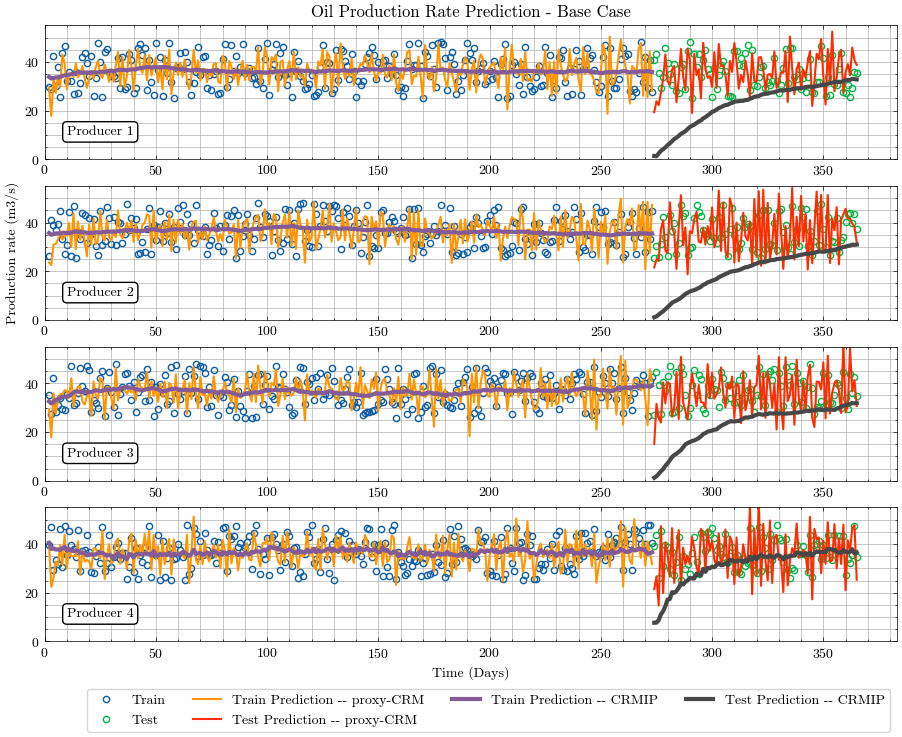

In [113]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time_train, oil_prod_train[:,p], label=f"Train", marker="o", markerfacecolor='None', markersize=4.5, ls='None')
    axes[i].plot(time_test, oil_prod_test[:,p], label=f"Test", marker="o", markerfacecolor='None', markersize=4.5, ls='None')

    axes[i].plot(time_train, q_hat_train[:,p], label=f"Train Prediction -- proxy-CRM", lw=1.5)
    axes[i].plot(time_test, q_hat_test[:,p], label=f"Test Prediction -- proxy-CRM", lw=1.5)

    axes[i].plot(time_train, q_hat_crmip[:,p], label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_crmip_test[:,p], label=f"Test Prediction -- CRMIP", lw=3)
    
    axes[i].set(xlim=(0, None), ylim=(0, None))
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time (Days)")
axes[1].set(ylabel="Production rate (m3/s)")
axes[0].set(title='Oil Production Rate Prediction - Base Case')
legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

<h4><b>One Well Shut-In Visualization:</b></h4>

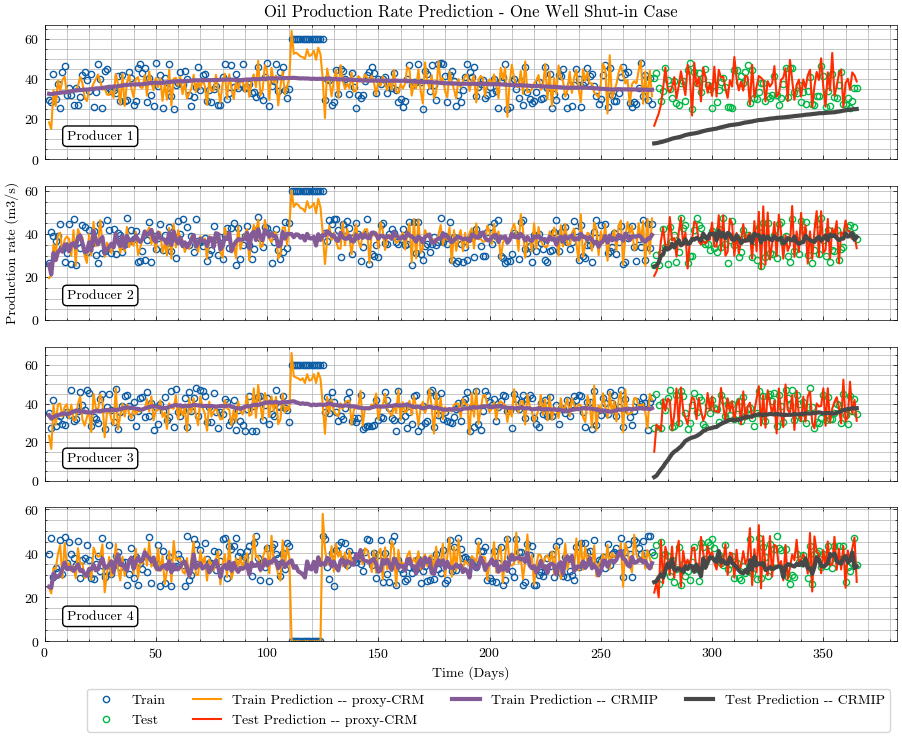

In [114]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharex=True)

for i, p in enumerate(prod):
    axes[i].plot(time_train, oil_prod_shut_in1_train[:,p], label=f"Train", marker="o", markerfacecolor='None', markersize=4.5, ls='None')
    axes[i].plot(time_test, oil_prod_shut_in1_test[:,p], label=f"Test", marker="o", markerfacecolor='None', markersize=4.5, ls='None')

    axes[i].plot(time_train, q_hat_sh_train[:,p], label=f"Train Prediction -- proxy-CRM", lw=1.5)
    axes[i].plot(time_test, q_hat_sh_test[:,p], label=f"Test Prediction -- proxy-CRM", lw=1.5)

    axes[i].plot(time_train, q_hat_sh1_crmip[:,p], label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_sh1_test_crmip[:,p], label=f"Test Prediction -- CRMIP", lw=3)
    
    axes[i].set(xlim=(0, None), ylim=(0, None))
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time (Days)")
axes[1].set(ylabel="Production rate (m3/s)")
axes[0].set(title='Oil Production Rate Prediction - One Well Shut-in Case')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

fig = plt.show()

<h4><b>Two Well Shut-In Visualization:</b></h4>

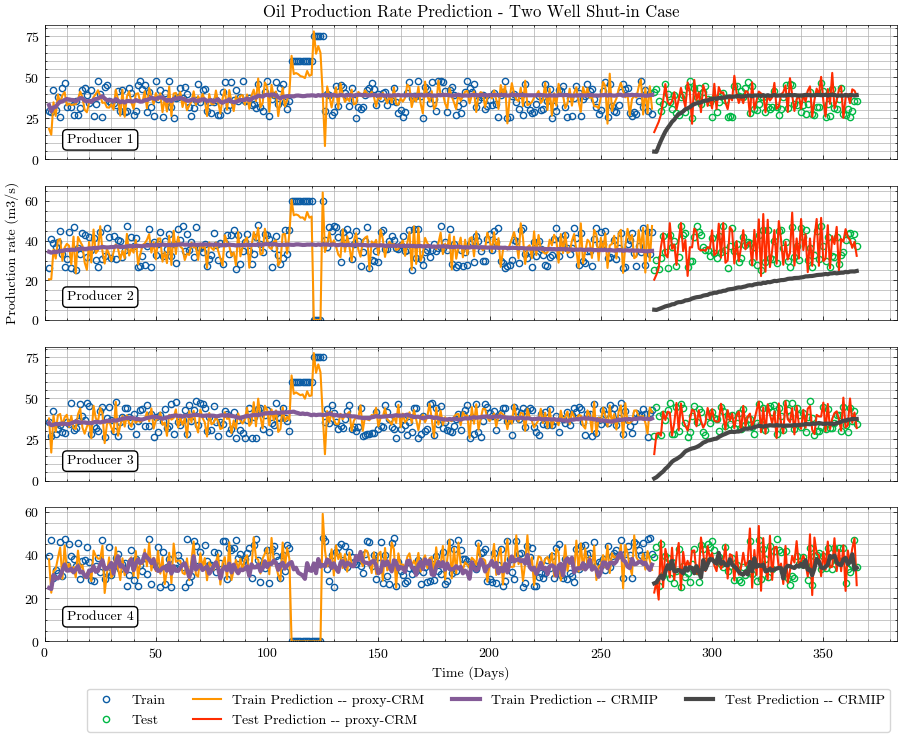

In [115]:
fig, axes = plt.subplots(len(prod.columns), figsize=(11, 8), sharex=True)

for i, p in enumerate(prod):
    axes[i].plot(time_train, oil_prod_shut_in2_train[:,p], label=f"Train", marker="o", markerfacecolor='None', markersize=4.5, ls='None')
    axes[i].plot(time_test, oil_prod_shut_in2_test[:,p], label=f"Test", marker="o", markerfacecolor='None', markersize=4.5, ls='None')
    
    axes[i].plot(time_train, q_hat_sh2_train[:,p], label=f"Train Prediction -- proxy-CRM", lw=1.5)
    axes[i].plot(time_test, q_hat_sh2_test[:,p], label=f"Test Prediction -- proxy-CRM", lw=1.5)

    axes[i].plot(time_train, q_hat_sh2_crmip[:,p], label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_sh2_test_crmip[:,p], label=f"Test Prediction -- CRMIP", lw=3)

    axes[i].set(xlim=(0, None), ylim=(0, None))
    axes[i].annotate(f"Producer {p+1}", xy=(10, 10), bbox=dict(boxstyle='round',pad=0.3, edgecolor='black', facecolor='white'))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time (Days)")
axes[1].set(ylabel="Production rate (m3/s)")
axes[0].set(title='Oil Production Rate Prediction - Two Well Shut-in Case')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

fig = plt.show()

<h3><b>4. Connectivity (lambda_ip) Results</b></h3>
<p>The heart of this project is the the <b>lambda_ip</b> parameter after all, so let's also visualize them in DataFrame.</p>

<h4><b>Base Case Lambda_ip:</b></h4>

In [105]:
connectivity = pd.DataFrame(
    base_pcrm.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.17,0.17,0.16,0.18
1,0.19,0.18,0.17,0.19
2,0.19,0.18,0.2,0.17
3,0.16,0.18,0.18,0.17
4,0.15,0.16,0.15,0.16


<h4><b>One Well Shut-In Case Lambda_ip:</b></h4>

In [106]:
shut_in_connectivity = pd.DataFrame(
    shut_in1_test.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.15,0.17,0.096,0.11
1,0.1,0.065,0.049,0.077
2,0.5,0.5,0.53,0.57
3,0.064,0.082,0.12,0.051
4,0.053,0.054,0.058,0.04


<h4><b>Two Well Shut-In Case Lambda_ip</b></h4>

In [107]:
shut_in_connectivity2 = pd.DataFrame(
    shut_in2_test.lambda_ip.reshape(4,5),
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.15,0.17,0.096,0.11
1,0.1,0.065,0.049,0.077
2,0.5,0.5,0.53,0.57
3,0.064,0.082,0.12,0.051
4,0.053,0.054,0.058,0.04


<h3><b>5. RMSE Calculation</b></h3>
<p>To test the accuracy of our model, we will use RMSE (Root Mean Square Error).</p>

<h4><b>5A. RMSE of Proxy-CRM:</b></h4>
<p>In order: Base Case - One Well Case - Two Well Case</p>

In [108]:
def rmse(test, pred, test_sh, pred_sh, test_sh2, pred_sh2):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  shut_in_rmse = np.sqrt(((test_sh-pred_sh)**2/len(test_sh)).sum())
  shut_in_rmse2 = np.sqrt(((test_sh2-pred_sh2)**2/len(test_sh)).sum())
  return original_rmse, shut_in_rmse, shut_in_rmse2

result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(oil_prod_test[:,j], q_hat_test[:,j], oil_prod_shut_in1_test[:,j], q_hat_sh_test[:,j], oil_prod_shut_in2_test[:,j], q_hat_sh2_test[:,j])))

print(f'Test Prediction RMSE of proxy-CRM:\n{np.array(result)}')

Test Prediction RMSE of proxy-CRM:
[[6.78142711 6.77653873 6.64671509]
 [6.18064151 4.83248976 4.96792416]
 [6.12030626 4.74524483 4.51334798]
 [6.35117778 5.07092078 5.1991367 ]]


In [109]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(oil_prod_train[:,j], q_hat_train[:,j], oil_prod_shut_in1_train[:,j], q_hat_sh_train[:,j], oil_prod_shut_in2_train[:,j], q_hat_sh2_train[:,j])))

print(f'Train Prediction RMSE of proxy-CRM:\n{np.array(result)}')

Train Prediction RMSE of proxy-CRM:
[[5.35424289 5.85272496 6.26402454]
 [5.12021828 5.52282226 5.23294427]
 [5.0729642  5.41136173 5.83159037]
 [5.0478695  5.30145414 5.09419693]]


<h4><b>5B. RMSE of CRMIP:</b></h4>
<p>In order: Base Case - One Well Case - Two Well Case</p>

In [110]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(oil_prod_test[:,j], q_hat_crmip_test[:,j], oil_prod_shut_in1_test[:,j], q_hat_sh1_test_crmip[:,j], oil_prod_shut_in1_test[:,j], q_hat_sh1_test_crmip[:,j])))

print(f'Test Prediction RMSE of CRMIP:\n{np.array(result)}')

Test Prediction RMSE of CRMIP:
[[17.2769469  19.37111089 10.87772934]
 [18.83101799  6.56267699 21.18741608]
 [17.28098207 13.47608741 14.67464078]
 [10.62965074  6.4594683   6.4565677 ]]


In [111]:
result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(oil_prod_train[:,j], q_hat_crmip[:,j], oil_prod_shut_in1_train[:,j], q_hat_sh1_crmip[:,j], oil_prod_shut_in2_train[:,j], q_hat_sh2_crmip[:,j])))

print(f'Train Prediction RMSE of CRMIP:\n{np.array(result)}')

Train Prediction RMSE of CRMIP:
[[ 6.66939074  8.10862358  9.31007973]
 [ 6.34250983  8.3542212   8.83909131]
 [ 6.18427409  7.85752822  8.77949835]
 [ 6.40503782 10.42395819 10.42344824]]


<h3> <b>Another Bonus: Visualization of Lambda_ip per timestep</b> </h3>
<p>This is to turn the lambda_ip into timesteps and show its behavior. In this case the data will be turned into graphs through excel.</p>

In [112]:
n_prod = prod_shut_in2_train.shape[1]
n_inj = inj_train.shape[1]
n_t = prod.values.shape[0]

lambda_ip = np.tile(shut_in2_test.lambda_ip.reshape((n_prod,n_inj)), (n_t,1,1))

mask = pCRM.sh_mask(prod_shut_in2_train)
result = pCRM.calc_sh_mask(lambda_ip, mask)

print(result[:,3,:])

[[0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0.09490408 0.52017638 0.07477962 0.06274423]
 [0.09531831 0